Main attempt at completing the challenge

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.circuit.library import QFT
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
import numpy as np
from fractions import Fraction
# Acquire the Quantum Rings Provider
qr_provider = QuantumRingsProvider()

Globals

In [28]:
N = 143


## This is the main problem of the challenge (how to implement this CMul gate)

Given 1 classical number a, and 1 number represented by a quantum state |x> we need to compute (a*x) mod N

In [26]:
def CMul(qbits,cqbit,a,N):
    qc = QuantumCircuit([qbit for qbit in qbits]+[cqbit],name=fr'CMUL$_{{{a}}}$')
    """" this is placeholder, should give here implementation of multiplication (x*a) mod N"""
    return qc.to_instruction()

In [27]:
def GetCircuit(N,n,t,a):
    control = QuantumRegister(n,'control')
    target = QuantumRegister(t,'target')
    classic = ClassicalRegister(n,'c')
    qc = QuantumCircuit(control,target,classic)
    qc.h(control)
    # For some reason diagrams I've seen online have X gate on last qubit of target register, mby we will implement it
    for i in range(len(control)):
        qc.append(CMul(qbits=target,cqbit=control[i],a=(a**(2**i) % N),N=N),[qbit for qbit in target]+[control[i]])
    qc.append(QFT(n,do_swaps=False,inverse=True),control)
    qc.measure(control,classic)
    return qc


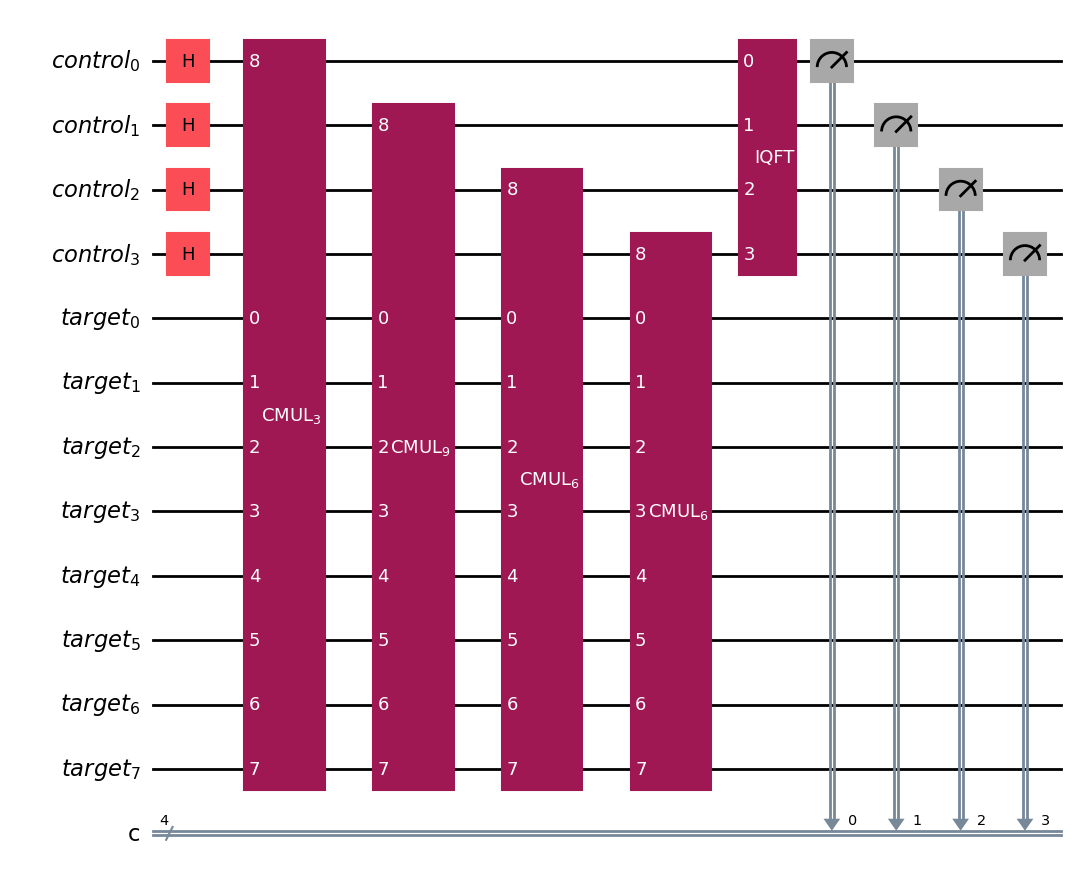

In [20]:
# Example circuit for hard-coded N

qc = GetCircuit(15,4,8,3)
qc.draw('mpl')


## Main body


In [ ]:
def GetaValue(N):
    # we should consider adding for example a list of guessed numbers to avoid repetition
    # another addition: smarter guesses - referenced in QRings github repo in file shors-overview.md
    a = np.random.default_rng().integers(2,N)
    return a

def shor_postprocess(measurement_counts, N, a):
    """
    Postprocess results from Shor's algorithm.
    
    Parameters:
    - measurement_counts (dict): Qiskit-style counts dict (e.g., {'010': 30, '110': 70})
    - N (int): The number to factor
    - a (int): Random co-prime integer used in modular exponentiation step
    
    Returns:
    - List of possible factors of N
    """
    results = []
    for measured_str in measurement_counts:
        decimal_val = int(measured_str, 2)
        if decimal_val == 0:
            continue

        # Estimate r: period of a^x mod N
        phase = decimal_val / (2 ** len(measured_str))
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator

        # Skip if r is even or invalid
        if r % 2 != 0:
            continue

        # Compute potential factors
        plus = pow(a, r // 2) + 1
        minus = pow(a, r // 2) - 1
        factor1 = np.gcd(plus, N)
        factor2 = np.gcd(minus, N)

        if 1 < factor1 < N:
            results.append(factor1)
        if 1 < factor2 < N:
            results.append(factor2)

    return list(set(results))  # Remove duplicates

def FindSolution(N,backend,shots):
    # currently just for 1 a value, should wrap it in a loop and look over multiple a values
    a = GetaValue(N)
    print(f"Value of a: {a}")
    if np.gcd(a,N)>1: return [np.gcd(a,N)]
    # dummy values for n and t, just to get the structure
    n = N.bit_length()
    t = 2*n
    print(f"Number of total qbits used: {n+t}")
    circuit = GetCircuit(N,n,t,a)
    circuit_transpiled = transpile(circuit, backend,initial_layout=[i for i in range(0, n+t)])
    print("Running the job")
    job = backend.run(circuit_transpiled, shots = shots)
    print("Done!")
    result = job.result()
    counts = result.get_counts()
    factors = shor_postprocess(counts, N=N, a=a)
    # It should loop there if factors is empty
    if len(factors)==2: return factors
    elif len(factors)==1: return [factors[0],N/factors[0]]
    else: return "None factors were found"


# this function should be better?

def shor_postprocess_better(measurement_counts,N,a):
    value = max((key for key in measurement_counts if key.strip('0')), key=measurement_counts.get)
    decimal_val = int(value, 2)
    results=[]
    # Estimate r: period of a^x mod N
    phase = decimal_val / (2 ** len(value))
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator

    # Skip if r is even or invalid
    if r % 2 != 0:
        return []

    # Compute potential factors
    plus = pow(a, r // 2) + 1
    minus = pow(a, r // 2) - 1
    factor1 = np.gcd(plus, N)
    factor2 = np.gcd(minus, N)

    if 1 < factor1 < N:
        results.append(factor1)
    if 1 < factor2 < N:
        results.append(factor2)

    return list(results)



## Running actual code here

t and n values should be changed, they are chosen a bit ambiguously now

In [30]:
n = N.bit_length()
t=2*n

backend = QrBackendV2(qr_provider, num_qubits = n+t)

In [50]:
shots = 1000
FindSolution(N,backend,shots)

Value of a: 52


[np.int64(13)]